In [1]:
!pip install tensorflow-gpu==2.0.0-beta0
!pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-beta0 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-beta0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

In [3]:
import pandas as pd

# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

In [4]:
print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.8.2
Hub version:  0.12.0
Eager mode:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


In [5]:
data_root = "/content/drive/MyDrive/피부병"

In [6]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="training", 
    shuffle=True,
    target_size=IMAGE_SHAPE)

/content/drive/MyDrive/피부병
Found 659 images belonging to 2 classes.
Found 2638 images belonging to 2 classes.


In [7]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)
['Benign' 'Malignant']


In [8]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [10]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(
    train_generator, 
    epochs=10,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=val_steps_per_epoch).history

Epoch 1/10
83/83 [==============================] - 488s 6s/step - loss: 0.6161 - acc: 0.7172 - val_loss: 0.4666 - val_acc: 0.7891
Epoch 2/10
83/83 [==============================] - 95s 1s/step - loss: 0.4386 - acc: 0.8108 - val_loss: 0.5112 - val_acc: 0.7602
Epoch 3/10
83/83 [==============================] - 93s 1s/step - loss: 0.3889 - acc: 0.8332 - val_loss: 0.4465 - val_acc: 0.7967
Epoch 4/10
83/83 [==============================] - 92s 1s/step - loss: 0.3520 - acc: 0.8431 - val_loss: 0.4215 - val_acc: 0.8103
Epoch 5/10
83/83 [==============================] - 92s 1s/step - loss: 0.3409 - acc: 0.8499 - val_loss: 0.5255 - val_acc: 0.7511
Epoch 6/10
83/83 [==============================] - 92s 1s/step - loss: 0.3206 - acc: 0.8597 - val_loss: 0.4308 - val_acc: 0.8058
Epoch 7/10
83/83 [==============================] - 92s 1s/step - loss: 0.3229 - acc: 0.8632 - val_loss: 0.4514 - val_acc: 0.8012
Epoch 8/10
83/83 [==============================] - 92s 1s/step - loss: 0.3194 - acc: 0.8

In [11]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

21/21 [==============================] - 19s 887ms/step - loss: 0.3892 - acc: 0.8179
Final loss: 0.39
Final accuracy: 81.79%


In [17]:
SHOE_SAVED_MODEL = "saved_models/shoe"
model.save(SHOE_SAVED_MODEL)

INFO:tensorflow:Assets written to: saved_models/shoe/assets


INFO:tensorflow:Assets written to: saved_models/shoe/assets


In [18]:
shoe_model = tf.keras.models.load_model(SHOE_SAVED_MODEL)

In [19]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [20]:
tf_model_predictions = shoe_model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 2)


In [21]:
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels

print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Benign,Malignant
0,0.27619991,0.72380006
1,0.00409530,0.99590474
2,0.00985249,0.99014753
3,0.14905217,0.85094786
4,0.98581439,0.01418563


In [22]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

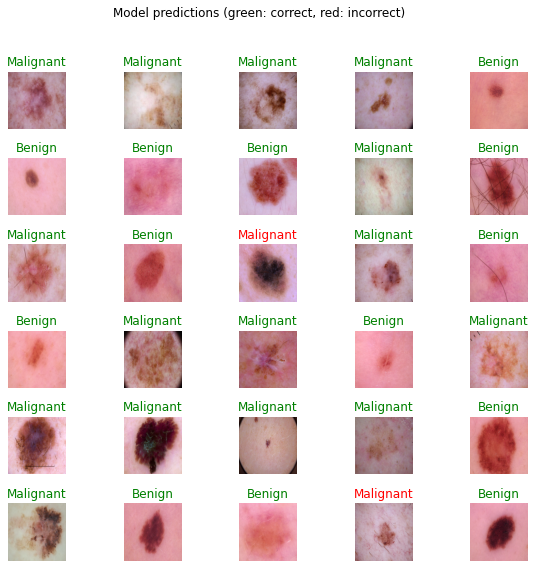

In [23]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [24]:
import os
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model("/content/saved_models/shoe") # path to the SavedModel directory
tflite_model = converter.convert()


# Save the model.
with open('model2.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
#https://medium.com/analytics-vidhya/how-to-do-image-classification-on-custom-dataset-using-tensorflow-52309666498e
# https://medium.com/analytics-vidhya/create-tensorflow-image-classification-model-with-your-own-dataset-in-google-colab-63e9d7853a3e